In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
import math

In [3]:

ticker_symbol = "AMZN"
stock_data = yf.download(ticker_symbol, start="2024-01-01", end="2025-10-17")

print(stock_data)
data = stock_data[['Close']].values
print(data)

/tmp/ipython-input-1430994793.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_symbol, start="2024-01-01", end="2025-10-17")
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            AMZN        AMZN        AMZN        AMZN      AMZN
Date                                                                
2024-01-02  149.929993  152.380005  148.389999  151.539993  47339400
2024-01-03  148.470001  151.050003  148.330002  149.199997  49425500
2024-01-04  144.570007  147.380005  144.050003  145.589996  56039800
2024-01-05  145.240005  146.589996  144.529999  144.690002  45153100
2024-01-08  149.100006  149.399994  146.149994  146.740005  46757100
...                ...         ...         ...         ...       ...
2025-10-10  216.369995  228.250000  216.000000  226.210007  72367500
2025-10-13  220.070007  220.679993  217.039993  217.699997  37809700
2025-10-14  216.389999  219.320007  212.600006  215.559998  45665600
2025-10-15  215.570007  217.710007  212.660004  216.619995  45909500
2025-10-16  214.470001  218.589996  212.809998  215.669998  42414600

[450 rows x 5 columns]
[[149.9299

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

time_step = 60
X, y = [], []
for i in range(time_step, len(scaled_data)):
    X.append(scaled_data[i - time_step:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [5]:

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
def build_model(model_type, units=100):
    model = Sequential()
    if model_type == "RNN":
        model.add(SimpleRNN(units, input_shape=(X_train.shape[1], 1)))
    elif model_type == "LSTM":
        model.add(LSTM(units, input_shape=(X_train.shape[1], 1)))
    elif model_type == "GRU":
        model.add(GRU(units, input_shape=(X_train.shape[1], 1)))
    else:
        raise ValueError("Invalid model type")

    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [6]:

models = ["RNN", "LSTM", "GRU"]
results = {}

for m in models:
    print(f"\n🔹 Training {m} Model...")
    model = build_model(m)
    history = model.fit(X_train, y_train, epochs=20, batch_size=16,
                        validation_data=(X_test, y_test), verbose=1)

    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

    results[m] = {'Model': model, 'MSE': mse, 'RMSE': rmse, 'MAE': mae,
                  'Predicted': y_pred_rescaled, 'Actual': y_test_rescaled}


🔹 Training RNN Model...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0981 - val_loss: 0.0031
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056 - val_loss: 0.0070
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0020 - val_l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1270 - val_loss: 0.0294
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0096 - val_loss: 0.0108
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0060 - val_loss: 0.0073
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0058 - val_loss: 0.0029
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0046 - val_loss: 0.0067
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0036 - val_l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.1447 - val_loss: 0.0023
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0067 - val_loss: 0.0028
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0042 - val_loss: 0.0056
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0022 - val_l

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step



 Model Comparison Metrics
  Model        MSE      RMSE       MAE
0   RNN  22.773271  4.772135  3.669748
1  LSTM  24.307064  4.930219  3.817317
2   GRU  17.196509  4.146867  2.917937


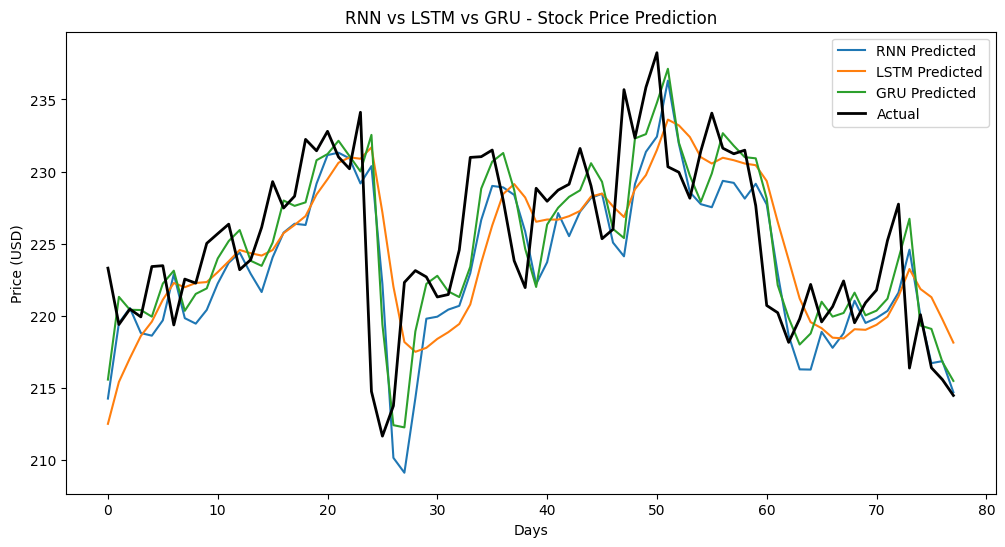

In [7]:

print("\n Model Comparison Metrics")
comparison = pd.DataFrame([
    {"Model": m, "MSE": r['MSE'], "RMSE": r['RMSE'], "MAE": r['MAE']}
    for m, r in results.items()
])
print(comparison)


plt.figure(figsize=(12,6))
for m in models:
    plt.plot(results[m]['Predicted'], label=f"{m} Predicted")
plt.plot(results['RNN']['Actual'], label='Actual', color='black', linewidth=2)
plt.title("RNN vs LSTM vs GRU - Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [8]:


predictions = {}

for m in models:
    model = results[m]['Model']
    last_60_days = scaled_data[-time_step:]
    last_60_days = np.reshape(last_60_days, (1, time_step, 1))
    next_day_scaled = model.predict(last_60_days)
    next_day_price = scaler.inverse_transform(next_day_scaled)
    predictions[m] = next_day_price[0][0]
    print(f" Predicted Next Day Closing Price using {m}: ${next_day_price[0][0]:.2f}")

best_model_name = comparison.sort_values(by="RMSE").iloc[0]['Model']
best_model = results[best_model_name]['Model']

print("\n Best Model Based on RMSE:", best_model_name)
print(f"Predicted Next Day Closing Price for {ticker_symbol} using Best Model ({best_model_name}): ${predictions[best_model_name]:.2f}")

print("\n Summary of All Model Predictions:")
for m, val in predictions.items():
    print(f"{m}: ${val:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
 Predicted Next Day Closing Price using RNN: $214.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
 Predicted Next Day Closing Price using LSTM: $216.50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
 Predicted Next Day Closing Price using GRU: $214.40

 Best Model Based on RMSE: GRU
Predicted Next Day Closing Price for AMZN using Best Model (GRU): $214.40

 Summary of All Model Predictions:
RNN: $214.07
LSTM: $216.50
GRU: $214.40
